In [1]:
# Importing dependencies
import numpy as np
np.random.seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import GRU
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
import data_prep_helper
plt.style.use('ggplot')

Using TensorFlow backend.


### Data Preprocessing

In [2]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [143]:
# Loading the dataset
do = data_prep_helper.ShiftChartData(chart_col=["Price", "High", "Low"])

In [144]:
df = do.chart_df

In [145]:
df.columns

Index(['bitcoin_Price', 'bitcoin_High', 'bitcoin_Low', 'sp500_Price',
       'sp500_High', 'sp500_Low', 'dax_Price', 'dax_High', 'dax_Low',
       'googl_Price', 'googl_High', 'googl_Low', 'gold_Price', 'gold_High',
       'gold_Low', 'alibaba_Price', 'alibaba_High', 'alibaba_Low',
       'amazon_Price', 'amazon_High', 'amazon_Low', 'bitcoin_Google_Trends',
       'cryptocurrency_Google_Trends', 'trading_Google_Trends',
       'bitcoin_pos_sents', 'bitcoin_neg_sents', 'bitcoin_quot_sents',
       'economy_pos_sents', 'economy_neg_sents', 'economy_quot_sents'],
      dtype='object')

In [6]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [7]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mse,rmse, r2, Y_test, Y_hat
  

In [93]:
# Plotting the predictions
def plot_data(Y_test,Y_hat, ax="", title=""):
    if ax:
        plot = ax
    else:
        fig, ax = plt.subplots(1, 1)
        plot = ax

    plot.plot(Y_test,c = 'r')
    plot.plot(Y_hat,c = 'y')
    plot.set_xlabel('Day')
    plot.set_ylabel('Price')
    if not title:
        plot.set_title("Stock Price Prediction using Multivariate-GRU")
    else:
        plot.set_title(title)
    plot.legend(['Actual','Predicted'],loc = 'lower right')
    #plot.show()

In [94]:
# Plotting the training errors
def plot_error(train_loss,val_loss, ax="", title=""):
    if ax:
        plot = ax
    else:
        fig, ax = plt.subplots(1, 1)
        plot = ax
        
    plot.plot(train_loss,c = 'r')
    plot.plot(val_loss,c = 'b')
    plot.set_ylabel('Loss')
    plot.set_xlabel('Epochs')
    if not title:
        plot.set_title('Loss Plot')
    else:
        plot.set_title(title)
    plot.legend(['train','val'],loc = 'lower right')
    #plot.show()

### Model Building

In [151]:
features = [
             'alibaba_Price_prev_month',
             'alibaba_Low_prev_month',
             'alibaba_High_prev_month',
             'amazon_Price_prev_month',
             'amazon_Low_prev_month',
             'amazon_High_prev_month',
             'googl_Price_prev_month',
             'googl_Low_prev_month',
             'googl_High_prev_month',
             'bitcoin_Google_Trends_prev_month',
             'economy_pos_sents_prev_month',
             'cryptocurrency_Google_Trends_prev_month',
             ]

features_test = [x.split("_prev_month")[0] for x in features]
#features_test = features

In [163]:
#creating the train and validation set
train = df[:1350]
val = df[1350:1500]
test = df[1500:]

In [164]:
train = do.get_causal_const_shift(train, past="all")[features]
val = do.get_causal_const_shift(val, past="all")[features_test]
test_bitcoin = test[["bitcoin_Price"]]

test = test[features_test]

In [165]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train)

sc = MinMaxScaler()
val = sc.fit_transform(val)

sc = MinMaxScaler()
test = sc.fit_transform(test)
print(train.shape,val.shape,test.shape)

(1319, 12) (119, 12) (389, 12)


In [166]:
true_c = MinMaxScaler()
test_bitcoin = true_c.fit_transform(test_bitcoin)

In [127]:
timesteps = 60
hl = [40,35]
lr = 1e-4
batch_size = 128
num_epochs = 200

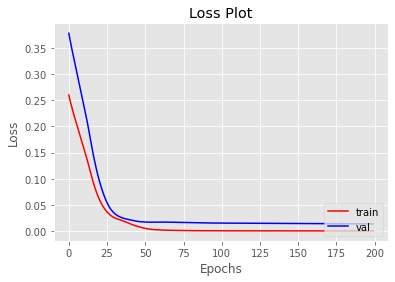

In [128]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

In [63]:
val.shape

(119, 12)

MSE = 0.006276913669097391
RMSE = 0.0792269756402287
R2-Score = 0.9053775236413028


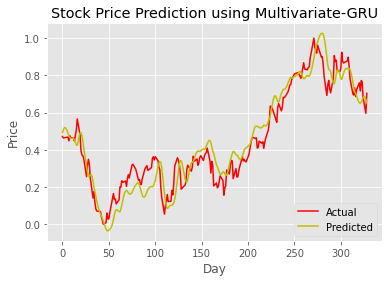

In [129]:
mse,rmse,r2_value,true,predicted = evaluate_model(model, test, 60)
print("MSE =",mse)
print("RMSE =",rmse)
print("R2-Score =",r2_value)
plot_data(true,predicted)

In [180]:
predicted.reshape(len(predicted))

array([ 0.4930231 ,  0.5068934 ,  0.5178085 ,  0.5196516 ,  0.51352304,
        0.5025874 ,  0.48953855,  0.4759918 ,  0.4660018 ,  0.45982757,
        0.4613694 ,  0.46376535,  0.4616572 ,  0.45321453,  0.438499  ,
        0.4266924 ,  0.42401698,  0.44599885,  0.4735363 ,  0.49082127,
        0.4915989 ,  0.4772981 ,  0.446443  ,  0.409629  ,  0.3748975 ,
        0.34170595,  0.3097545 ,  0.27927902,  0.26066202,  0.2538604 ,
        0.26342958,  0.26657316,  0.25516203,  0.23066834,  0.19978684,
        0.173123  ,  0.15146706,  0.12474415,  0.10241761,  0.08340172,
        0.06751247,  0.05458482,  0.04504931,  0.03252258,  0.01755572,
        0.00315559, -0.01167876, -0.02534586, -0.03498565, -0.03598312,
       -0.03166484, -0.0269218 , -0.02122771, -0.01124511,  0.00434703,
        0.02542368,  0.05022191,  0.06854606,  0.078138  ,  0.07714559,
        0.07229868,  0.06813943,  0.06664871,  0.08163046,  0.10198453,
        0.1257946 ,  0.14953943,  0.16694342,  0.17719464,  0.18

In [168]:
true_c.inverse_transform(true.reshape(-1,1))

array([[ 8104.96743413],
       [ 8034.50650086],
       [ 8042.59218173],
       [ 8050.6778626 ],
       [ 8058.76354346],
       [ 8066.84922433],
       [ 8074.9349052 ],
       [ 7887.80914799],
       [ 8143.08564393],
       [ 8051.83295986],
       [ 8046.05747353],
       [ 8040.2819872 ],
       [ 8034.50650086],
       [ 7876.25817533],
       [ 8154.6366166 ],
       [ 8433.01505787],
       [ 8989.77194041],
       [ 8721.40434212],
       [ 8453.03674382],
       [ 8184.66914553],
       [ 7398.04790692],
       [ 7185.51000985],
       [ 7121.97966018],
       [ 7001.84954445],
       [ 6694.20863909],
       [ 6386.56773373],
       [ 6078.92682837],
       [ 6636.83880818],
       [ 6955.64565378],
       [ 6721.16090864],
       [ 6028.10254863],
       [ 5684.65362801],
       [ 5341.20470738],
       [ 4997.75578675],
       [ 5318.87282689],
       [ 4787.52808422],
       [ 4460.63555774],
       [ 4345.12583108],
       [ 4339.63911906],
       [ 4334.15240704],


In [114]:
pd.DataFrame(true, index=test.index[:len(true)])

,0
Date,
2019-02-16,0.243375
2019-02-17,0.259081
2019-02-18,0.292779
2019-02-19,0.324289
2019-02-20,0.360759
...,...
2019-05-20,0.889132
2019-05-21,0.850328
2019-05-22,0.860248


In [65]:
# Save a model
model.save('models/gru_12_feat_month.h5')

## Cross Validation

In [66]:
timesteps = 60
hl = [40,35]
lr = 1e-4
batch_size = 128
num_epochs = 200

In [67]:
do = data_prep_helper.ModelData(chart_col=["Price", "High", "Low"])

In [91]:
def gen_scaled_train_val_test(df, split=""):
    if split:
        split_range = range(0,split)
    else:
        split_range = range(2,3)
    for split_number in split_range:
        train = df[:900+(split_number*300)]
        val = df[900+(split_number*300):1100+(split_number*300)]
        test = df[1100+(split_number*300):]    

        train = do.get_causal_const_shift(train, past="all")[features]
        val = do.get_causal_const_shift(val, past="all")[features]
        test = do.get_causal_const_shift(test, past="all")[features]

        sc = MinMaxScaler()
        train = sc.fit_transform(train)
        sc = MinMaxScaler()
        val = sc.fit_transform(val)
        sc = MinMaxScaler()
        test = sc.fit_transform(test)
        
        yield train, val, test, split_number

S_0_MSE: 0.01376430635474011
S_0_RMSE: 0.11732138063771713
S_0_R2: 0.663866668815361
S_1_MSE: 0.004588399127907673
S_1_RMSE: 0.0677377230788552
S_1_R2: 0.8704677992556562
S_2_MSE: 0.010074715751389945
S_2_RMSE: 0.10037288354625439
S_2_R2: 0.7634548146690646


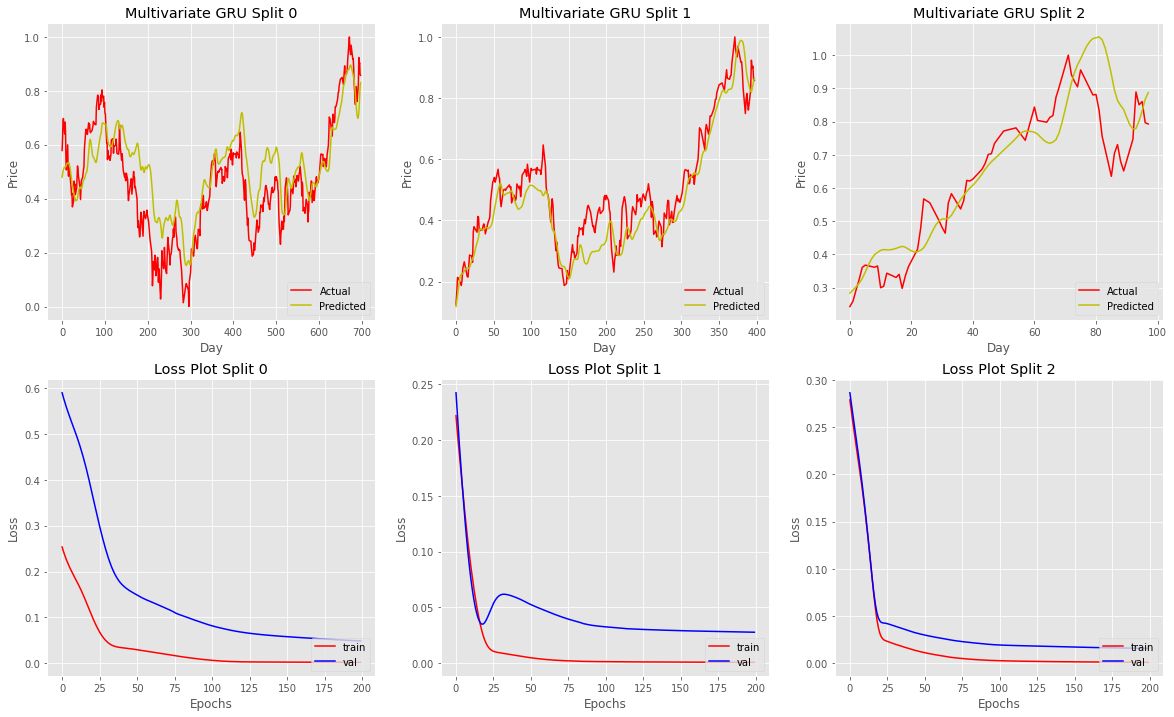

In [95]:
result_dict={}
fig, ax = plt.subplots(2, 3, figsize=(20,12))

for train,val,test,split_index in gen_scaled_train_val_test(do.chart_df,split=3):
    
    cross_val_results = list()
    train_loss = pd.DataFrame()
    val_loss = pd.DataFrame()
    model,train_error,val_error = fit_model(train, val,timesteps,hl,lr,batch_size,num_epochs)
    model.save('models/gru_12_feat_month_S{}.h5'.format(split_index))

    
    mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
    result_dict["S_{}_MSE".format(split_index)] = mse
    result_dict["S_{}_RMSE".format(split_index)] = rmse
    result_dict["S_{}_R2".format(split_index)] = r2_value

    plot_data(true, predicted, ax[0][split_index], "Multivariate GRU Split {}".format(split_index))
    plot_error(train_error, val_error, ax[1][split_index], "Loss Plot Split {}".format(split_index))
    
for key, val in result_dict.items():
    print("{}: {}".format(key, val))